Train ocr with keras

dataseti githubdan çek ve unziple

In [2]:
!wget -q https://github.com/onuralpArsln/toJava/raw/refs/heads/main/PayDayProject/dataset.zip

In [3]:
!unzip -q dataset.zip

In [5]:
!wget -q -O source.jpg https://raw.githubusercontent.com/onuralpArsln/toJava/main/PayDayProject/source/source.jpg

In [7]:
!wget -q -O source.jpg https://raw.githubusercontent.com/onuralpArsln/toJava/main/PayDayProject/source/test.jpg

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os

class SpecialLettersOCR:
    def __init__(self):
        self.model = None
        self.class_names = None

    def train(self, dataset_path, img_size=(64, 64)):
        """Train model on single-letter classification dataset"""
        # Load training data
        train_path = os.path.join(dataset_path, 'train')
        val_path = os.path.join(dataset_path, 'validation')

        X_train, y_train, self.class_names = self._load_data(train_path, img_size)
        X_val, y_val, _ = self._load_data(val_path, img_size)

        # Create and train model
        self.model = self._create_model(img_size, len(self.class_names))

        self.model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=30,
            batch_size=32
        )

        # Save model
        self.model.save('special_letters_model.h5')

    def _load_data(self, data_path, img_size):
        """Load and preprocess classification training data"""
        images = []
        labels = []
        class_names = sorted(os.listdir(data_path))

        for idx, class_name in enumerate(class_names):
            class_path = os.path.join(data_path, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                img = img / 255.0
                images.append(img)
                labels.append(idx)

        return (np.array(images).reshape(-1, img_size[0], img_size[1], 1),
                np.array(labels),
                class_names)

    def _create_model(self, img_size, num_classes):
        """Create the CNN model"""
        return models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def detect_and_recognize(self, image_path):
        """Detect and recognize multiple letters in a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Binarize image
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort contours left-to-right
        contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

        detected_text = ""
        boxes = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Filter out noise
            if w * h < 100:  # Adjust this threshold based on your images
                continue

            # Extract letter
            letter_img = binary[y:y+h, x:x+w]

            # Preprocess for classification
            letter_img = cv2.resize(letter_img, (64, 64))
            letter_img = letter_img / 255.0
            letter_img = letter_img.reshape(1, 64, 64, 1)

            # Classify letter
            pred = self.model.predict(letter_img, verbose=0)
            letter_idx = np.argmax(pred)
            confidence = np.max(pred)

            if confidence > 0.5:  # Adjust confidence threshold as needed
                detected_text += self.class_names[letter_idx]
                boxes.append((x, y, w, h))

                # Draw bounding box
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        return detected_text, image, boxes

# Usage example
def main():
    # Initialize OCR
    ocr = SpecialLettersOCR()

    # Train on your dataset (only need to do this once)
    ocr.train("dataset")  # Path to your dataset folder

    # OR load pre-trained model if you already trained it
    # ocr.model = tf.keras.models.load_model('special_letters_model.h5')
    # ocr.class_names = ['your', 'class', 'names']

    # Detect and recognize letters in new image
    test_image = "source.jpg"  # Image with multiple letters
    text, annotated_image, boxes = ocr.detect_and_recognize(test_image)

    print(f"Detected text: {text}")
    cv2.imwrite("result.jpg", annotated_image)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8394 - loss: 0.4472 - val_accuracy: 0.9700 - val_loss: 0.0801
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9700 - loss: 0.0712 - val_accuracy: 0.9925 - val_loss: 0.0212
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9907 - loss: 0.0326 - val_accuracy: 0.9950 - val_loss: 0.0190
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0017 - val_accuracy: 0.9975 - val_loss

Detected text: a


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import os

def preprocess_image(image_path):
    """
    Preprocess the input image for character detection
    """
    # Read image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarization
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    denoised = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return img, denoised

def detect_characters(binary_image):
    """
    Detect individual characters in the binary image
    Returns list of bounding boxes (x, y, w, h)
    """
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours
    char_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out noise (adjust these thresholds based on your images)
        if w * h > 100 and w/h < 3 and h/w < 3:
            char_boxes.append((x, y, w, h))

    # Sort characters left to right
    char_boxes.sort(key=lambda box: box[0])

    return char_boxes

def extract_character(image, box, target_size=(64, 64)):
    """
    Extract and preprocess a single character from the image
    """
    x, y, w, h = box
    char_img = image[y:y+h, x:x+w]

    # Add padding to make it square
    height, width = char_img.shape
    max_dim = max(height, width)
    pad_vert = (max_dim - height) // 2
    pad_horz = (max_dim - width) // 2

    char_img = cv2.copyMakeBorder(
        char_img,
        pad_vert,
        pad_vert + (max_dim - height) % 2,
        pad_horz,
        pad_horz + (max_dim - width) % 2,
        cv2.BORDER_CONSTANT,
        value=0
    )

    # Resize to target size
    char_img = cv2.resize(char_img, target_size)

    # Normalize
    char_img = char_img / 255.0

    return char_img

class MultiCharacterOCR:
    def __init__(self, model_path, class_names):
        self.model = tf.keras.models.load_model(model_path)
        self.class_names = class_names

    def predict_string(self, image_path):
        """
        Detect and classify all characters in an image
        Returns the predicted string and character confidences
        """
        # Preprocess image
        original_img, binary_img = preprocess_image(image_path)

        # Detect character regions
        char_boxes = detect_characters(binary_img)

        # Extract and classify each character
        predicted_string = ""
        confidences = []

        for box in char_boxes:
            # Extract character
            char_img = extract_character(binary_img, box)
            char_img = char_img.reshape(1, 64, 64, 1)  # Adjust shape based on your model

            # Predict
            pred = self.model.predict(char_img, verbose=0)
            char_idx = np.argmax(pred)
            confidence = np.max(pred)

            predicted_string += self.class_names[char_idx]
            confidences.append(confidence)

            # Draw bounding box (for visualization)
            x, y, w, h = box
            cv2.rectangle(original_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

        return predicted_string, confidences, original_img

# Example usage:
def main():
    # Load your trained classification model and class names
    model_path = "path/to/your/trained_model.h5"
    class_names = ["your", "character", "classes"]  # Replace with your actual classes

    # Initialize OCR
    ocr = MultiCharacterOCR(model_path, class_names)

    # Process an image
    image_path = "path/to/test_image.jpg"
    predicted_text, confidences, annotated_img = ocr.predict_string(image_path)

    print(f"Predicted text: {predicted_text}")
    print(f"Character confidences: {confidences}")

    # Save or display the annotated image
    cv2.imwrite("annotated_result.jpg", annotated_img)

if __name__ == "__main__":
    main()

Train için idinrimeler ve importları yap

In [13]:
!pip install easyocr
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [14]:
import easyocr
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [15]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, letter in enumerate(os.listdir(root_dir)):
            letter_path = os.path.join(root_dir, letter)
            for img in os.listdir(letter_path):
                self.image_paths.append(os.path.join(letter_path, img))
                self.labels.append(letter)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.image_paths[idx]).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [17]:
train_dataset = CustomOCRDataset(root_dir='dataset/train', transform=transform)
val_dataset = CustomOCRDataset(root_dir='dataset/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [20]:
from easyocr.model import Model

custom_characters = ['letter1', 'letter2', 'letter3', 'letter4']
reader = easyocr.Reader([], gpu=torch.cuda.is_available(), character_list=custom_characters)

ImportError: cannot import name 'Model' from 'easyocr.model' (/usr/local/lib/python3.11/dist-packages/easyocr/model/__init__.py)

train_dataset = CustomOCRDataset(root_dir='/dataset/train', transform=transform)
val_dataset = CustomOCRDataset(root_dir='/dataset/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [19]:
image_path = 'source.jpg'
results = reader.readtext(image_path)
for (bbox, text, prob) in results:
    print(f'Text: {text}, Confidence: {prob:.4f}')

Text: 6 6 0 I 0*8' & Av XX } 1 * 1>)1X € | b H: H 0 J6, Confidence: 0.0145
Text: 1 B C 0 E } 6 H I j K L m n 0 P Q R $ T U V W X Y 2, Confidence: 0.0859
Text: 8 F F: E E: > WE % HH Q, Confidence: 0.0866
Text: :0 " |, Confidence: 0.3795
Text: f & € & 0.0 *8, Confidence: 0.2087
Text: 0 | 2 3 4 5 6 7 9 9, Confidence: 0.2763
Text: (Period, degree, Minute; Second), Confidence: 0.5829
Text: Unknolvn, Confidence: 0.5048


In [3]:
!pip -q install tensorflow opencv-python matplotlib


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,372 (1.20 MB)

 Trainable params: 314,372 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8029 - loss: 0.6294 - val_accuracy: 0.9479 - val_loss: 0.1355
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9385 - loss: 0.1429 - val_accuracy: 0.9661 - val_loss: 0.0747
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9722 - loss: 0.0737 - val_accuracy: 0.9870 - val_loss: 0.0554
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9773 - loss: 0.0621 - val_accuracy: 0.9870 - val_loss: 0.0328
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9832 - loss: 0.0503 - val_accuracy: 0.9896 - val_loss: 0.0255
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9870 - loss: 0.0394 - val_accuracy: 0.9974 - val_loss: 0.0116
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9887 - loss: 0.0364 - val_accuracy: 0.9922 - val_loss: 0.0249
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9880 - loss: 0.0403 - val_accuracy: 0.9974 

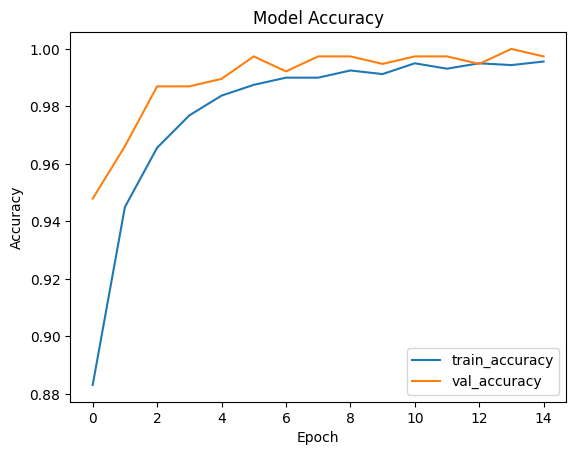

In [7]:
# Parameters
img_width, img_height = 32, 32
batch_size = 32
epochs = 15  # Increase if you have a larger dataset
train_data_dir = 'dataset/train'
validation_data_dir = 'dataset/validation'
num_classes = len(os.listdir(train_data_dir))  # Assuming one folder per class

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Only rescaling for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',  # set to "rgb" if your images are colored
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the model for later use
model.save('custom_ocr_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

.h5 dosyasını indirdikten sonra başka yerlerde kullanman mümkün


In [8]:
!wget -1 -O source.jpg https://raw.githubusercontent.com/onuralpArsln/toJava/main/PayDayProject/source/source.jpg


--2025-02-02 14:31:00--  https://raw.githubusercontent.com/onuralpArsln/toJava/main/PayDayProject/source/source.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47486 (46K) [image/jpeg]
Saving to: ‘source.jpg’

source.jpg          100%[===================>]  46.37K  --.-KB/s    in 0.02s   

2025-02-02 14:31:00 (2.54 MB/s) - ‘source.jpg’ saved [47486/47486]



Use your model

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained OCR model
model = load_model('/content/custom_ocr_model.h5')  # Update with your model path

# Define image preprocessing function
def preprocess_image(img):
    img = cv2.resize(img, (28, 28))  # Resize to match model input
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load and preprocess the main image
image_path = '/content/source.jpg'  # Update with your image path
original_img = cv2.imread(image_path)
gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours (detected letters)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Reverse class index dictionary
class_indices = {'A': 0, 'B': 1, 'C': 2}  # Adjust based on training data
labels = {v: k for k, v in class_indices.items()}

# Loop through detected letters
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    # Extract and preprocess letter
    letter_img = gray[y:y+h, x:x+w]
    letter_img = preprocess_image(letter_img)

    # Predict letter
    pred = model.predict(letter_img)
    predicted_class = np.argmax(pred, axis=1)[0]
    predicted_letter = labels[predicted_class]

    # Draw bounding box and label
    cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(original_img, predicted_letter, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Convert BGR to RGB for Matplotlib
rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display image in Colab
plt.figure(figsize=(10, 10))
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

# Save result
cv2.imwrite("/content/output_marked.png", original_img)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 2304, but received input with shape (1, 1600)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 28, 28, 1), dtype=float32)
  • training=False
  • mask=None